In [50]:
import pandas as pd
import numpy as np

In [51]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1455, 82)
Test data shape: (1459, 81)


Skew is: 1.8902547272110803


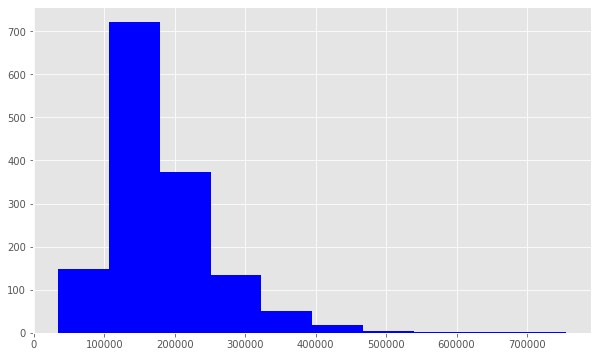

In [52]:
print ("Skew is:", train.SalePrice.skew())
plt.hist(train.SalePrice, color='blue')
plt.show()

Skew is: 0.12174203145727748


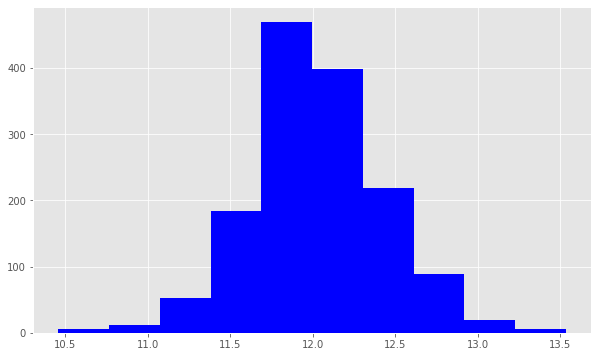

In [53]:
target = np.log(train.SalePrice)
print ("Skew is:", target.skew())
plt.hist(target, color='blue')
plt.show()

In [54]:
numeric_features = train.select_dtypes(include=[np.number])
corr = numeric_features.corr()
print (corr['SalePrice'].sort_values(ascending=False)[:5], '\n')
print (corr['SalePrice'].sort_values(ascending=False)[-5:])

SalePrice      1.000000
OverallQual    0.792879
GrLivArea      0.725145
TotalBsmtSF    0.644318
GarageCars     0.644097
Name: SalePrice, dtype: float64 

YrSold          -0.029754
OverallCond     -0.078465
MSSubClass      -0.082984
EnclosedPorch   -0.128565
KitchenAbvGr    -0.136082
Name: SalePrice, dtype: float64


In [55]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

In [56]:
quality_pivot = train.pivot_table(index='OverallQual',
                  values='SalePrice', aggfunc=np.median)
quality_pivot

,SalePrice
OverallQual,
1,50150
2,60000
3,87500
4,108000
5,133000
6,160000
7,200141
8,270000
9,345000


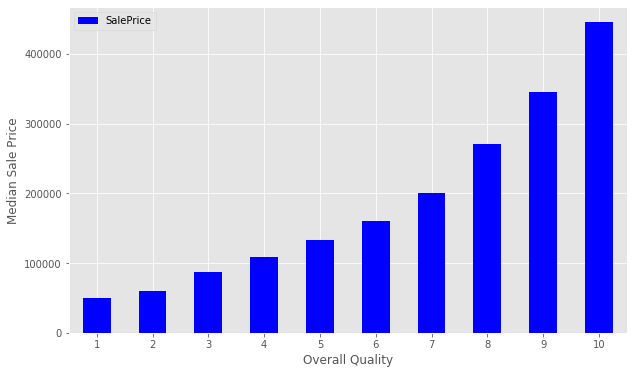

In [57]:
quality_pivot.plot(kind='bar', color='blue')
plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

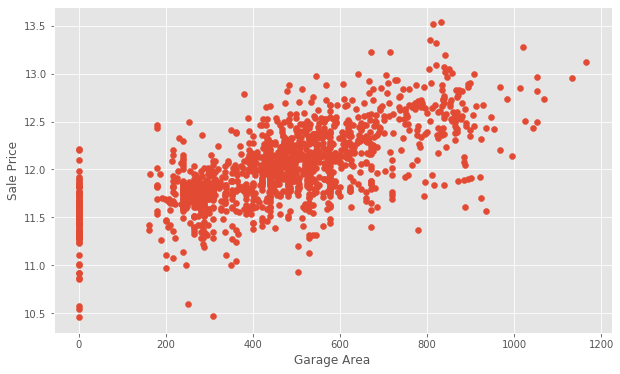

In [58]:
plt.scatter(x=train['GarageArea'], y=target)
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

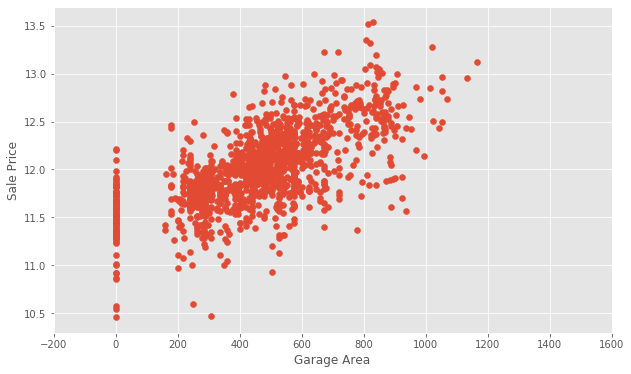

In [59]:
train = train[train['GarageArea'] < 1200]
plt.scatter(x=train['GarageArea'], y=np.log(train.SalePrice))
plt.xlim(-200,1600) # This forces the same scale as before
plt.ylabel('Sale Price')
plt.xlabel('Garage Area')
plt.show()

In [60]:
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls

,Null Count
Feature,
PoolQC,1449
MiscFeature,1402
Alley,1364
Fence,1174
FireplaceQu,689
LotFrontage,258
GarageQual,81
GarageCond,81
GarageFinish,81


In [61]:
print ("Original: \n")
print (train.Street.value_counts(), "\n")

Original: 

Pave    1450
Grvl       5
Name: Street, dtype: int64 



In [62]:
train['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
test['enc_street'] = pd.get_dummies(train.Street, drop_first=True)
print ('Encoded: \n')
print (train.enc_street.value_counts())

Encoded: 

1    1450
0       5
Name: enc_street, dtype: int64


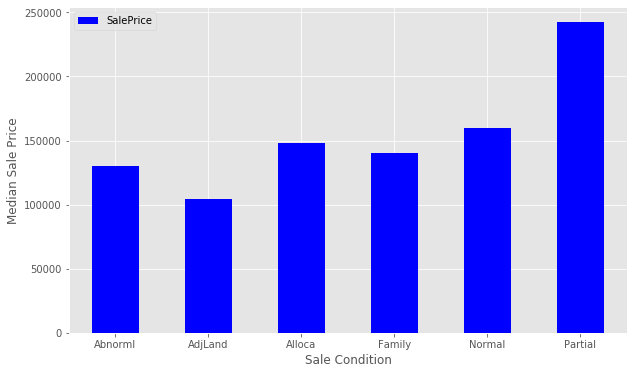

In [63]:
condition_pivot = train.pivot_table(index='SaleCondition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

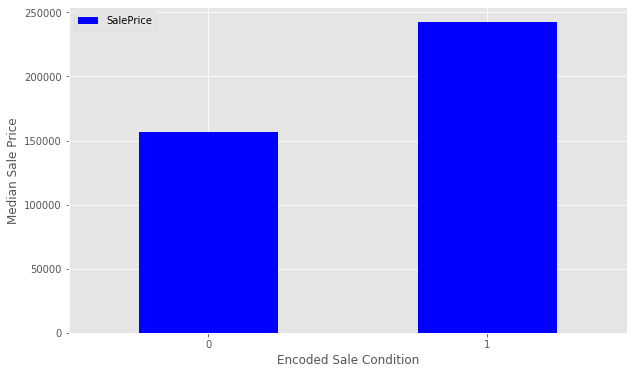

In [64]:
def encode(x):
 return 1 if x == 'Partial' else 0
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

condition_pivot = train.pivot_table(index='enc_condition', values='SalePrice', aggfunc=np.median)
condition_pivot.plot(kind='bar', color='blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation=0)
plt.show()

In [65]:
data = train.select_dtypes(include=[np.number]).interpolate().dropna()
sum(data.isnull().sum() != 0)

0

In [66]:
#model
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
                          X, y, random_state=42, test_size=.33)
from sklearn import linear_model
lr = linear_model.LinearRegression()

model = lr.fit(X_train, y_train)
print ("R^2 is: \n", model.score(X_test, y_test))

R^2 is: 
 0.8882477709262531


In [67]:
predictions = model.predict(X_test)
from sklearn.metrics import mean_squared_error
print ('RMSE is: \n', mean_squared_error(y_test, predictions))

RMSE is: 
 0.01784179451956794


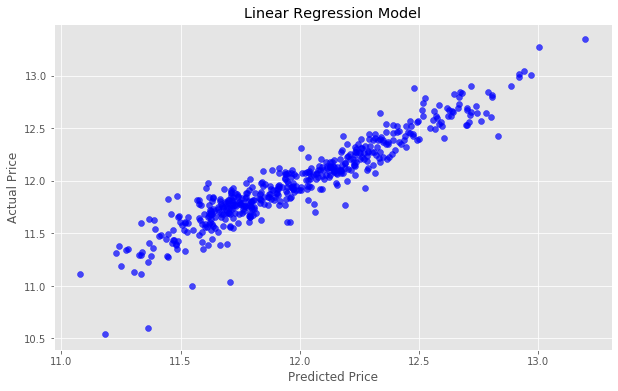

In [68]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha=.7,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

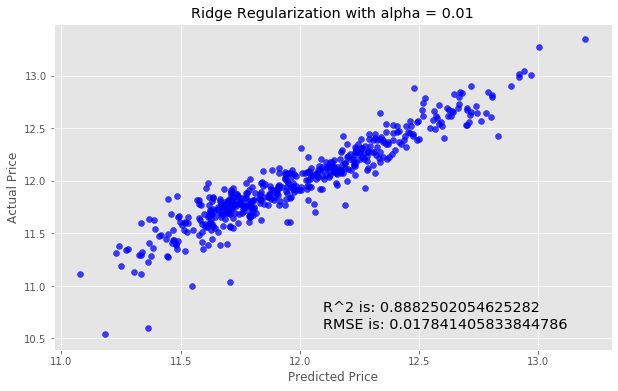

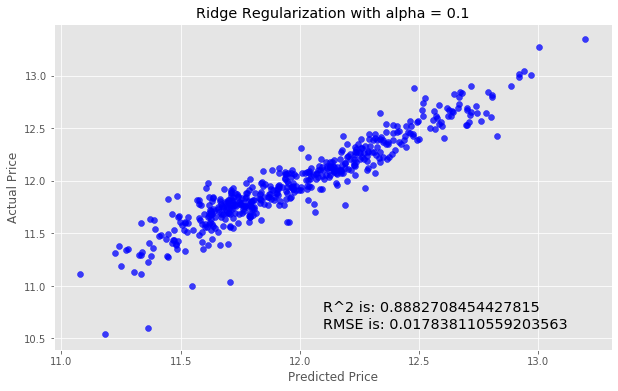

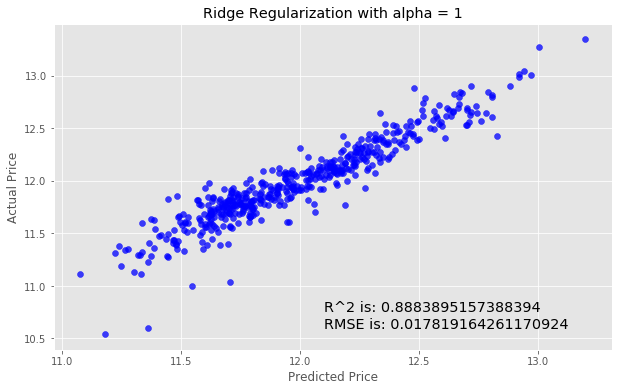

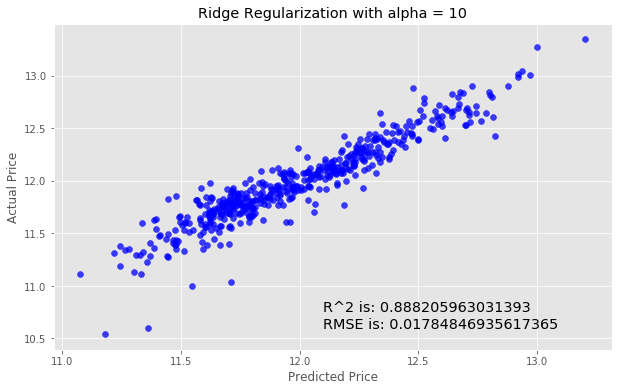

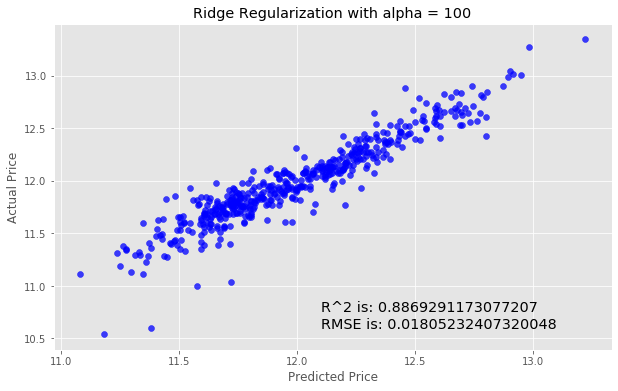

In [69]:
for i in range (-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha=alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)

    plt.scatter(preds_ridge, actual_values, alpha=.75, color='b')
    plt.xlabel('Predicted Price')
    plt.ylabel('Actual Price')
    plt.title('Ridge Regularization with alpha = {}'.format(alpha))
    overlay = 'R^2 is: {}\nRMSE is: {}'.format(
                    ridge_model.score(X_test, y_test),
                    mean_squared_error(y_test, preds_ridge))
    plt.annotate(s=overlay,xy=(12.1,10.6),size='x-large')
    plt.show()

In [70]:
submission = pd.DataFrame()
submission['Id'] = test.Id
feats = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()
predictions = model.predict(feats)
final_predictions = np.exp(predictions)

print ("Original predictions are: \n", predictions[:5], "\n")
print ("Final predictions are: \n", final_predictions[:5])

submission['SalePrice'] = final_predictions
submission.head()

submission.to_csv('submission.csv', index=False)

Original predictions are: 
 [11.76725362 11.71929504 12.07656074 12.20632678 12.11217655] 

Final predictions are: 
 [128959.49172585 122920.74024358 175704.82598102 200050.83263755
 182075.46986405]
